# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 



<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TF-IDF</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#N-Gramm-with-LogisticRegression" data-toc-modified-id="N-Gramm-with-LogisticRegression-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>N-Gramm with LogisticRegression</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#BertClassifier" data-toc-modified-id="BertClassifier-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>BertClassifier</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Импорт необходимых библиотек

In [3]:
%pip install scikit-learn==0.22.1
%pip install wordcloud
%pip install transformers==2.8

You should consider upgrading via the '/Users/a1234/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer 

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import transformers
import numpy as np

from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import lightgbm as lgbm
from lightgbm import LGBMClassifier
import math
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/a1234/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/a1234/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/a1234/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/a1234/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Подготовка

In [6]:
df = pd.read_csv('/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
df.shape

(159571, 2)

Посмотрим на распределение целевой переменной:

<AxesSubplot:xlabel='toxic'>

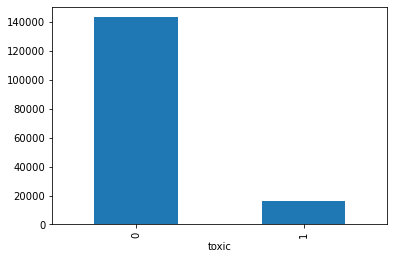

In [8]:
df.groupby(['toxic']).size().plot.bar()

Данные не сбалансированы.

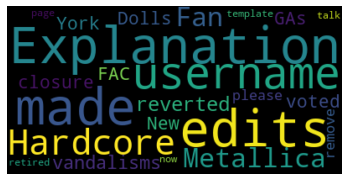

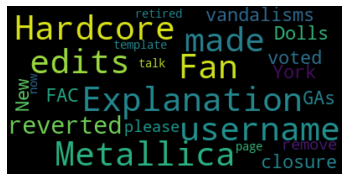

In [9]:
import os

from os import path
from wordcloud import WordCloud


# Generate a word cloud image
wordcloud = WordCloud().generate(df['text'][0])

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(df['text'][0])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
corpus = df['text'].values.astype('U')

In [11]:
%%time
%pip install nltk
nltk.download('wordnet')
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
        
    return lemm_text


def clear_text(text):
    pattern = r'[^a-zA-Z ]'
    replacement = ' '
    t = re.sub(pattern, replacement, text)
    return(' '.join(t.split()).lower())
print("Исходный текст:", corpus[0])
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[0])))

You should consider upgrading via the '/Users/a1234/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


[nltk_data] Downloading package wordnet to /Users/a1234/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Очищенный и лемматизированный текст: explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now
CPU times: user 1.61 s, sys: 395 ms, total: 2 s
Wall time: 4.6 s


In [14]:
%%time
%pip install nltk
nltk.download('wordnet')
df['text'] = df['text'].apply(lambda x : lemmatize(clear_text(x)))

You should consider upgrading via the '/Users/a1234/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package wordnet to /Users/a1234/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CPU times: user 23min 2s, sys: 4min 14s, total: 27min 17s
Wall time: 27min 37s


In [15]:
corpus = df['text'].values.astype('U')

## TF-IDF

## Обучение

In [16]:
model = LogisticRegression(class_weight='balanced', random_state=12345, max_iter=1e6)

In [17]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/a1234/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
%%time

best_score=0
bestnrgam = 0
for i in range(2,4):
    X_train, X_test, y_train, y_test = train_test_split(corpus, df['toxic'], test_size=0.25, random_state=12345)
    count_tf_idf = TfidfVectorizer(ngram_range=(1, i), stop_words=stopwords, max_df = 0.975)
    X_train = count_tf_idf.fit_transform(X_train)
    X_test = count_tf_idf.transform(X_test)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score=f1_score(y_test, pred)
    if best_score<score:
        best_score=score
        bestnrgam = [1,i]
print(best_score, bestnrgam)

0.7525660624590522 [1, 2]
CPU times: user 4min 6s, sys: 40.7 s, total: 4min 47s
Wall time: 2min 43s


In [19]:
X_train, X_test, y_train, y_test = train_test_split(corpus, df['toxic'], test_size=0.25, random_state=12345)

count_tf_idf = TfidfVectorizer(ngram_range=(1, 2), stop_words=stopwords, max_df = 0.975)
X_train = count_tf_idf.fit_transform(X_train)
X_test = count_tf_idf.transform(X_test)

In [21]:
def eval(model, params):
    grid = GridSearchCV(model, param_grid=params, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    pred = grid.predict(X_test)                                                   
    accuracy = f1_score(y_test, pred)
    print('F1', accuracy)
    print(grid.best_params_)

In [22]:
%%time
model = LogisticRegression(class_weight='balanced', random_state=12345)
eval(model, {'max_iter' : np.logspace(1, 6, 5)})

F1 0.7525660624590522
{'max_iter': 177.82794100389228}
CPU times: user 1min 13s, sys: 17.5 s, total: 1min 31s
Wall time: 5min 12s


In [23]:
%%time
model = LogisticRegression(class_weight='balanced', max_iter=177,  random_state=12345)
eval(model, {'penalty':['l1', 'l2']})

F1 0.7525660624590522
{'penalty': 'l2'}
CPU times: user 1min 12s, sys: 17.4 s, total: 1min 29s
Wall time: 1min 36s


In [24]:
%%time
model = LogisticRegression(class_weight='balanced', max_iter=177, penalty='l2', random_state=12345)
eval(model, {'C' : np.logspace(-2, 1, 4)})

F1 0.7862961188308577
{'C': 10.0}
CPU times: user 3min 17s, sys: 53.8 s, total: 4min 10s
Wall time: 7min 10s


In [25]:
%%time
model = LogisticRegression(class_weight='balanced', max_iter=177, penalty='l2', C=10, random_state=12345)
eval(model, {'tol' : np.logspace(-6, 4, 3)})

F1 0.7862961188308577
{'tol': 0.1}
CPU times: user 3min 39s, sys: 51.1 s, total: 4min 30s
Wall time: 7min 19s


## N-Gramm with LogisticRegression

In [27]:
%%time
model = LogisticRegression(class_weight='balanced', random_state=12345, max_iter=1e6)
best_score=0
bestnrgam = 0
for i in range(2,4):
    X_train, X_test, y_train, y_test = train_test_split(corpus, df['toxic'], test_size=0.25, random_state=12345)
    count_vect = CountVectorizer(ngram_range=(1, i), stop_words=stopwords, max_df = 0.975, min_df = 0.005)
    X_train = count_vect.fit_transform(list(X_train))
    X_test = count_vect.transform(X_test)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score=f1_score(y_test, pred)
    if best_score<score:
        best_score=score
        bestnrgam = [1,i]
print(best_score, bestnrgam)

0.5104208904387317 [1, 3]
CPU times: user 1min 32s, sys: 10.9 s, total: 1min 43s
Wall time: 1min 48s


In [28]:
X_train, X_test, y_train, y_test = train_test_split(corpus, df['toxic'], test_size=0.25, random_state=12345)
count_vect = CountVectorizer(ngram_range=(1, 3), stop_words=stopwords, max_df = 0.975, min_df = 0.005)
X_train = count_vect.fit_transform(list(X_train))
X_test = count_vect.transform(X_test)
print("Размер:", X_train.shape, X_test.shape)

Размер: (119678, 1001) (39893, 1001)


In [29]:
%%time
model = LogisticRegression(class_weight='balanced', random_state=12345)
eval(model, {'max_iter' : np.logspace(1, 6, 5)})

F1 0.510255051842882
{'max_iter': 10.0}
CPU times: user 542 ms, sys: 293 ms, total: 835 ms
Wall time: 48.4 s


## BERT

In [31]:
df = pd.read_csv('toxic_comments.csv')
df = df.sample(df.shape[0]//10, random_state=12345).reset_index(drop=True)

df_tweets = df.sample(3200, random_state=12345).reset_index(drop=True)
#df_tweets = df
data=[]
y = []
for i in range(len(df_tweets)):
    if len(df_tweets['text'][i])<=512:
        data.append(df_tweets['text'][i])
        y.append(df_tweets['toxic'][i])
#df_tweets = pd.DataFrame(data)
y = pd.DataFrame(y)
tokenizer = transformers.BertTokenizer(
    vocab_file='bert-base-uncased-vocab.txt')
tokenized = df_tweets['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))
df_tweets.shape, tokenized.shape, y.shape

((3200, 2), (3200,), (2582, 1))

In [32]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(3200, 512)

In [33]:
config = transformers.BertConfig.from_json_file(
    'config.json')
model = transformers.BertModel.from_pretrained('bert-base-uncased',
                                  config=config)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [34]:
%%time
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 1h 33min 42s, sys: 29min 42s, total: 2h 3min 24s
Wall time: 1h 36min 47s


In [35]:
X = np.concatenate(embeddings) 
y = df_tweets['toxic']
print(X.shape, df_tweets['toxic'].shape)

(3200, 768) (3200,)


In [36]:
model = LogisticRegression(class_weight='balanced', random_state=12345, max_iter=1e6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1600, 768), (1600, 768), (1600,), (1600,))

In [37]:
model.fit(X_train, y_train)
print(model.predict(X_test))
#print(model.score(y_test, model.predict(X_test)))
print('Accuracy', model.score(X_test, y_test))
print('F1:', f1_score(y_test, model.predict(X_test)))

[0 0 0 ... 1 0 0]
Accuracy 0.91375
F1: 0.6584158415841584


Метрика F1 получилась хуже

## Выводы

Обучена модель для классифицикации комментариев на позитивные и негативные.Построена модель со значением метрики качества F1 не меньше 0.75